In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
import plotly.offline as po
import plotly.graph_objs as go
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
%matplotlib inline

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 200)

Given the information about the presence of weapons, the time of day of the call, the subject's perceived race, the officer's race

INquiry into whether race plays a role in whether or not an arrest is made

In [2]:
#Looking at the data and getting a sense of the values
df = pd.read_csv('Terry_Stops.csv')
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,18 - 25,-1,20150000203647,54389,Arrest,None,7412,1979,M,White,White,Male,2015-06-17T00:00:00,13:18:00,SHOPLIFT - THEFT,--THEFT - SHOPLIFT,ONVIEW,WEST PCT 2ND W - KING BEATS,N,N,East,C,C3
1,18 - 25,-1,20150000203762,54306,Field Contact,None,7725,1974,F,White,Unknown,Female,2015-06-17T00:00:00,16:36:00,THREATS (INCLS IN-PERSON/BY PHONE/IN WRITING),"--DV - ARGUMENTS, DISTURBANCE (NO ARREST)",911,WEST PCT 2ND W - KING,N,N,West,K,K2
2,18 - 25,-1,20150000203886,60810,Offense Report,Lethal Cutting Instrument,6805,1973,M,White,White,Male,2015-07-06T00:00:00,17:36:00,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 2ND W - DAVID,N,Y,West,D,D1
3,18 - 25,-1,20150000203886,60811,Offense Report,Lethal Cutting Instrument,6805,1973,M,White,White,Male,2015-06-18T00:00:00,15:00:00,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 2ND W - DAVID,N,Y,West,D,D1
4,18 - 25,-1,20150000204122,54333,Arrest,Handgun,7472,1981,M,White,Black or African American,Male,2015-06-17T00:00:00,19:36:00,WARRANT - FELONY PICKUP,--WARRANT SERVICES - FELONY,ONVIEW,EAST PCT 2ND W - BEATS,N,Y,East,C,C3


In [3]:
#Viewing the data types 
df.dtypes

Subject Age Group           object
Subject ID                   int64
GO / SC Num                  int64
Terry Stop ID                int64
Stop Resolution             object
Weapon Type                 object
Officer ID                  object
Officer YOB                  int64
Officer Gender              object
Officer Race                object
Subject Perceived Race      object
Subject Perceived Gender    object
Reported Date               object
Reported Time               object
Initial Call Type           object
Final Call Type             object
Call Type                   object
Officer Squad               object
Arrest Flag                 object
Frisk Flag                  object
Precinct                    object
Sector                      object
Beat                        object
dtype: object

In [4]:
#View the shape of the data
df.shape

(46305, 23)

In [5]:
#Check Null Values
df.isna().sum()

Subject Age Group             0
Subject ID                    0
GO / SC Num                   0
Terry Stop ID                 0
Stop Resolution               0
Weapon Type                   0
Officer ID                    0
Officer YOB                   0
Officer Gender                0
Officer Race                  0
Subject Perceived Race        0
Subject Perceived Gender      0
Reported Date                 0
Reported Time                 0
Initial Call Type             0
Final Call Type               0
Call Type                     0
Officer Squad               605
Arrest Flag                   0
Frisk Flag                    0
Precinct                      0
Sector                        0
Beat                          0
dtype: int64

In [6]:
#We want to create our Target variable so we will check the Stop_Resolution 
df['Stop Resolution'].value_counts()

Field Contact               18555
Offense Report              15448
Arrest                      11397
Referred for Prosecution      728
Citation / Infraction         177
Name: Stop Resolution, dtype: int64

In [7]:
#We create our Target variable (Arrest)
df['Arrested'] = df['Stop Resolution'] == 'Arrest'
df['Arrested'] = df['Arrested'].replace([True, False], [1,0])

In [8]:
#Started to look at value counts and first started with Precinct. We see that there are a few values like '-', 'OOJ', 'FK ERROR' and 'Unknown'. 
#We want to clean this up
df['Precinct'].value_counts()

West         11118
North        10184
-             9811
East          6109
South         5547
Southwest     2320
SouthWest      965
Unknown        200
OOJ             32
FK ERROR        19
Name: Precinct, dtype: int64

In [9]:
#IS THIS NECESSARY? PRECINCT ISN'T ONE OF OUR FEATURES THAT WE ARE MEASURING AGAINST THE ARRESTS
#Dropped OOJ, FK ERROR, and Unkown, these were a small portion of our data and we didnt think it would impact the model
df['Precinct'] = df['Precinct'].replace(['SouthWest','-'], ['Southwest','Not Specified']) 
df = df[df.Precinct != 'OOJ']
df = df[df.Precinct != 'FK ERROR']
df = df[df.Precinct != 'Unknown']
df['Precinct'].value_counts()

West             11118
North            10184
Not Specified     9811
East              6109
South             5547
Southwest         3285
Name: Precinct, dtype: int64

In [10]:
#We believe that an Officer's race will have an impact on our model
#add data viz
df['Officer Race'].value_counts()

White                            34892
Hispanic or Latino                2635
Two or More Races                 2569
Asian                             1962
Black or African American         1820
Not Specified                     1342
Nat Hawaiian/Oth Pac Islander      447
American Indian/Alaska Native      317
Unknown                             70
Name: Officer Race, dtype: int64

In [11]:
# ax = sns.distributions(data=df, x=df['White_Officer'], y=df['Arrested'])
# plt.tight_layout()
# plt.show()

In [12]:
#We want to group the 'Unkown' with 'Not Specified'
df['Officer Race'] = df['Officer Race'].replace('Unknown', 'Not Specified')

In [13]:
df['Officer Race'].value_counts()

White                            34892
Hispanic or Latino                2635
Two or More Races                 2569
Asian                             1962
Black or African American         1820
Not Specified                     1412
Nat Hawaiian/Oth Pac Islander      447
American Indian/Alaska Native      317
Name: Officer Race, dtype: int64

In [14]:
#Creating the value of whether or not the officer is White or not and look at the value counts to see what that data looks like 
df['White_Officer'] = (df['Officer Race'] == 'White')
df['White_Officer'] = df['White_Officer'].replace([True, False], [1,0])
df['White_Officer'].value_counts()

1    34892
0    11162
Name: White_Officer, dtype: int64

In [15]:
#We also think that a Subject's Perceived Race will have an impact on the rate of arrests so we look at those value counts 
df['Subject Perceived Race'].value_counts()

White                                        22497
Black or African American                    13719
Unknown                                       2506
-                                             1863
Hispanic                                      1664
Asian                                         1479
American Indian or Alaska Native              1326
Multi-Racial                                   800
Other                                          152
Native Hawaiian or Other Pacific Islander       48
Name: Subject Perceived Race, dtype: int64

In [16]:
#We converted '-','Unknown' into 'Not Specified', we left 'Other' in its own category
df['Subject Perceived Race'] = df['Subject Perceived Race'].replace(['-', 'Unknown'],['Not Specified', 'Not Specified'])
df['Subject Perceived Race'].value_counts()

White                                        22497
Black or African American                    13719
Not Specified                                 4369
Hispanic                                      1664
Asian                                         1479
American Indian or Alaska Native              1326
Multi-Racial                                   800
Other                                          152
Native Hawaiian or Other Pacific Islander       48
Name: Subject Perceived Race, dtype: int64

In [17]:
#We want to see if there is a relationship of arrests and race so we created a feature called 'Subject_POC' by grouping all those who do not have 'White' as their value
df['Subject_POC'] = df['Subject Perceived Race'] != 'White'
df['Subject_POC'] = df['Subject_POC'].replace([True, False], [1,0])
df['Subject_POC'].value_counts()

1    23557
0    22497
Name: Subject_POC, dtype: int64

In [18]:
#We want to explore percieved gender
df['Subject Perceived Gender'].value_counts()

Male                                                         36088
Female                                                        9354
Unable to Determine                                            314
-                                                              272
Unknown                                                         22
Gender Diverse (gender non-conforming and/or transgender)        4
Name: Subject Perceived Gender, dtype: int64

In [19]:
#Grouping Unable to Determine with Gender Diverse. We recognize that although they may not identify as Gender Diverse we know that perception of one's gender is an indication of how 
#Society treats you. This in no way is being used to disregard individuals' gender identity.
df['Subject Perceived Gender'] = df['Subject Perceived Gender'].replace('-', 'Unknown')
df['Subject Perceived Gender'] = df['Subject Perceived Gender'].replace('Unable to Determine', 'Gender Diverse (gender non-conforming and/or transgender)')
df['Subject Perceived Gender'].value_counts()

Male                                                         36088
Female                                                        9354
Gender Diverse (gender non-conforming and/or transgender)      318
Unknown                                                        294
Name: Subject Perceived Gender, dtype: int64

In [20]:
#Looking at Call Type count
df['Call Type'] = df['Call Type'].replace('-','NOT SPECIFIED')
df['Call Type'].value_counts()

911                              20666
NOT SPECIFIED                    13056
ONVIEW                            8816
TELEPHONE OTHER, NOT 911          3194
ALARM CALL (NOT POLICE ALARM)      315
TEXT MESSAGE                         7
Name: Call Type, dtype: int64

In [21]:
#Turning the Year_of_Report to datetime value 
df['Year_of_Report'] = pd.to_datetime(df['Reported Date']).dt.year

In [22]:
#Turning the Officer YOB into an interger
df['Officer YOB'] = df['Officer YOB'].astype(int)

In [23]:
df['Year_of_Report'] = df['Year_of_Report'].astype(int)

In [24]:
df.dtypes

Subject Age Group           object
Subject ID                   int64
GO / SC Num                  int64
Terry Stop ID                int64
Stop Resolution             object
Weapon Type                 object
Officer ID                  object
Officer YOB                  int64
Officer Gender              object
Officer Race                object
Subject Perceived Race      object
Subject Perceived Gender    object
Reported Date               object
Reported Time               object
Initial Call Type           object
Final Call Type             object
Call Type                   object
Officer Squad               object
Arrest Flag                 object
Frisk Flag                  object
Precinct                    object
Sector                      object
Beat                        object
Arrested                     int64
White_Officer                int64
Subject_POC                  int64
Year_of_Report               int64
dtype: object

In [25]:
df['Officer_Age'] = df['Year_of_Report'] - df['Officer YOB']

In [26]:
df['Hour'] = pd.to_datetime(df['Reported Time'], format='%H:%M:%S').dt.hour

In [27]:
df['Hour'] = df['Hour'].replace(0,24)

In [28]:
df['Morning'] = (df['Hour'] >= 5) & (df['Hour'] < 12)
df['Morning'] = df['Morning'].replace([True,False], [1,0])

In [29]:
df['Afternoon']= (df['Hour'] >= 12) & (df['Hour'] < 17)
df['Afternoon'] = df['Afternoon'].replace([True,False], [1,0])

In [30]:
df['Evening'] = (df['Hour'] >= 17) & (df['Hour'] < 21)
df['Evening'] = df['Evening'].replace([True,False], [1,0])

In [31]:
df['Night'] = (df['Hour'] >= 21) & (df['Hour'] <= 24)
df['Night'] = df['Night'].replace([True,False], [1,0])

In [32]:
df['Hour'].value_counts()

18    2809
2     2692
19    2534
3     2459
17    2434
23    2287
1     2286
16    2212
15    2119
24    2095
14    2026
22    1949
11    1888
13    1802
10    1788
21    1645
12    1569
5     1467
9     1426
4     1423
20    1413
8     1277
7     1266
6     1188
Name: Hour, dtype: int64

In [33]:
under_70 = df[df['Officer_Age']<= 70]

In [34]:
mean_age = round(under_70['Officer_Age'].mean(), 0)

In [35]:
df['Officer_Age'].value_counts()

31     3047
30     2880
33     2780
32     2709
29     2565
34     2505
28     2485
26     2207
27     2180
25     1878
35     1872
24     1741
36     1369
37     1307
38     1212
39     1078
40      994
42      925
23      913
41      858
44      748
45      747
46      707
43      652
48      652
47      631
49      581
50      573
54      439
51      415
53      399
52      350
55      321
56      262
22      252
57      232
58      182
59       96
60       79
61       39
63       34
120      31
119      28
21       19
62       19
65       16
64       14
67       12
121       4
68        4
118       3
66        2
116       2
69        1
70        1
117       1
115       1
Name: Officer_Age, dtype: int64

In [36]:
# Changed extreme values of age to the average age
df['Officer_Age'] = df['Officer_Age'].replace([120,119,121,118,116,117,115],[mean_age,mean_age,mean_age,mean_age,mean_age,mean_age,mean_age])

In [37]:
df['Officer_Age'].value_counts()

31.0    3047
30.0    2880
33.0    2780
32.0    2709
29.0    2565
34.0    2505
28.0    2485
26.0    2207
27.0    2180
35.0    1942
25.0    1878
24.0    1741
36.0    1369
37.0    1307
38.0    1212
39.0    1078
40.0     994
42.0     925
23.0     913
41.0     858
44.0     748
45.0     747
46.0     707
43.0     652
48.0     652
47.0     631
49.0     581
50.0     573
54.0     439
51.0     415
53.0     399
52.0     350
55.0     321
56.0     262
22.0     252
57.0     232
58.0     182
59.0      96
60.0      79
61.0      39
63.0      34
62.0      19
21.0      19
65.0      16
64.0      14
67.0      12
68.0       4
66.0       2
69.0       1
70.0       1
Name: Officer_Age, dtype: int64

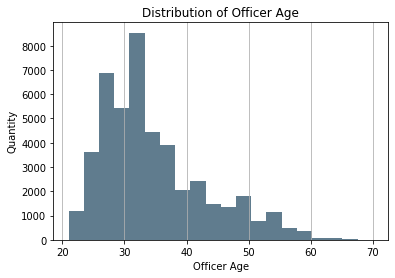

In [38]:
size, scale = 100, 10

df['Officer_Age'].plot.hist(grid=True, bins=20, rwidth=1,
                   color='#607c8e')
plt.title('Distribution of Officer Age')
plt.xlabel('Officer Age')
plt.ylabel('Quantity')
plt.grid(axis='y', alpha=0.75)

In [39]:
#Created a value of 'under_17' from the 'Subject Age Group'
df['under_17'] = df['Subject Age Group']=='1 - 17'
df['under_17'] = df['under_17'].replace([True, False], [1,0])

In [40]:
df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat', 'Arrested',
       'White_Officer', 'Subject_POC', 'Year_of_Report', 'Officer_Age', 'Hour',
       'Morning', 'Afternoon', 'Evening', 'Night', 'under_17'],
      dtype='object')

In [41]:
features = ['White_Officer', 'Subject_POC', 'Officer_Age', 'under_17','Morning', 'Afternoon', 'Evening', 'Night']

In [42]:
len(features)

8

In [43]:
y = df['Arrested']

In [44]:
X = df[features]

In [45]:
#pandas_profiling.ProfileReport(X)

In [46]:
df['Arrested'].value_counts()

0    34712
1    11342
Name: Arrested, dtype: int64